In [487]:
import psycopg2
from sqlalchemy import create_engine

import pandas as pd
import numpy as np
import string

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import log_loss, roc_curve, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from create_staging_tables import create_loyalty_scores_df

import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

In [488]:
engine = create_engine('postgresql://localhost:5432/wa_leg_staging')

In [535]:
merged_final_df = pd.read_sql_query('select * from "merged_final"',con=engine)
rep_score_df = pd.read_sql_query('select * from "rep_score"',con=engine)

In [597]:
bill_text_df = pd.read_sql_query('select * from "bill_text"',con=engine)

In [598]:
def clean_bill_text(bill_text):
    bill_text_lower = bill_text.lower()
    bill_text_prepared = bill_text_lower.replace('\n', ' ') 
    return bill_text_prepared

bill_text_df['bill_text'] = bill_text_df['bill_text'].apply(prepare_bill_text)

def find_read_first_time_date(bill_text):
    '''Find first_read_date from the bill text. Bills have different formatting.'''
    try:
        bill_split = bill_text.split('first time ')[1]
        end_points = range(2, 26)
        all_datetimes = []
        for end_point in end_points:
            try:
                date = pd.Timestamp(bill_split[0:end_point])
            except:
                date = ''
            if type(date) != str:
                all_datetimes.append(date)
        date = all_datetimes[-1]
        return date
    except:
        return None    
        
bill_text_df['first_date_read'] = bill_text_df['bill_text'].apply(find_read_first_time_date)

In [600]:
def create_clean_X(merged_final_df, bill_text_df, rep_score_df):
    
    # Add bill_text
    clean = merged_final_df.merge(bill_text_df, how='left', on=['unique_id', 'htm_url'])
    clean.drop(['index_x', 'index_y'], axis=1, inplace=True)
    clean.rename(columns={'sponsor_party': 'primary_sponsor_party'}, inplace=True)

    
    # Add rep_score and replace -1 values, then make dem_score
    clean['bill_num'] = clean['bill_id'].apply(lambda x: x.split()[1])
    clean['bill_num_unique'] = clean['biennium'] + ' ' + clean['bill_num']
    clean = clean.merge(rep_score_df, how='left', on='bill_num_unique')

    def replace_with_p_sponsor_party(row):
        primary_sponsor_party = row['primary_sponsor_party']
        if row['rep_score'] == -1:
            return primary_sponsor_party
        else:
            return row['rep_score']
    clean['rep_score'] = clean.apply(replace_with_p_sponsor_party, axis=1)
    clean['dem_score'] = 1 - clean['rep_score']
    
    
    # Add loyalty scores
#     clean = clean.merge(loyalty_df, how = 'left', on='voter_id')
#     clean.drop(['index_x', 'index_y'], axis=1, inplace=True)
    
    
    # Feature Engineering functions
    def create_congress_nums(biennium):
        '''Numbers bienniums so that 1991 is 1 and 1993 is 3.'''
        first_year = int((biennium.split('-'))[0])
        return first_year - 1990
    
    def find_num_sponsors(secondary_sponsors):
        if type(secondary_sponsors) == str:
            return round((len(secondary_sponsors) / 5) + 1)
        else: return 1
    
    # Feature Engineering
    clean['bill_length'] = clean['bill_text'].apply(lambda x: len(x))
    clean['congress_num'] = clean['biennium'].apply(create_congress_nums)
    clean['num_sponsors'] = clean['secondary_sponsors'].apply(find_num_sponsors)

    return clean

In [601]:
clean = create_clean_X(merged_final_df, bill_text_df, rep_score_df)

In [602]:
clean.head()

,vote,vote_date,voter_id,voting_agency,bill_unique,unique_id,biennium,bill_id,htm_url,sponsor_agency,...,bill_num,bill_num_unique,index,secondary_sponsors,primary_sponsor_id,rep_score,dem_score,bill_length,congress_num,num_sponsors
0,1,1993-02-16,347,1,1993-94 SB 5426,12053.0,1993-94,SB 5426,http://app.leg.wa.gov/documents/billdocs/1993-...,1,...,5426,1993-94 5426,12050,"{445,309,339,562}",562,0.5,0.5,34836,3,4
1,1,1993-02-16,360,1,1993-94 SB 5426,12053.0,1993-94,SB 5426,http://app.leg.wa.gov/documents/billdocs/1993-...,1,...,5426,1993-94 5426,12050,"{445,309,339,562}",562,0.5,0.5,34836,3,4
2,1,1993-02-16,361,1,1993-94 SB 5426,12053.0,1993-94,SB 5426,http://app.leg.wa.gov/documents/billdocs/1993-...,1,...,5426,1993-94 5426,12050,"{445,309,339,562}",562,0.5,0.5,34836,3,4
3,1,1993-02-16,387,1,1993-94 SB 5426,12053.0,1993-94,SB 5426,http://app.leg.wa.gov/documents/billdocs/1993-...,1,...,5426,1993-94 5426,12050,"{445,309,339,562}",562,0.5,0.5,34836,3,4
4,1,1993-02-16,512,1,1993-94 SB 5426,12053.0,1993-94,SB 5426,http://app.leg.wa.gov/documents/billdocs/1993-...,1,...,5426,1993-94 5426,12050,"{445,309,339,562}",562,0.5,0.5,34836,3,4


In [604]:
clean['vote_year'] = clean['vote_date'].apply(lambda x: x.year)

In [605]:
clean['first_year_read'] = clean['first_date_read'].apply(lambda x: x.year)

In [606]:
clean['first_year_read'] = clean['first_year_read'].fillna(clean['vote_year'])

In [619]:
clean['years_until_vote'] = clean['vote_year'] - clean['first_year_read']

In [620]:
def remove_neg(num):
    if num < 0:
        return 0
    else: return num

In [621]:
clean['years_until_vote'] = clean['years_until_vote'].apply(remove_neg)

In [622]:
clean['years_until_vote'].unique()

array([0., 1.])

In [645]:
def flip_vote(vote):
    if vote == 1:
        return 0
    if vote == 0:
        return 1
    else:
        return vote

In [646]:
clean['vote'] = clean['vote'].apply(flip_vote)

### Dummies

In [ ]:
clean_new = clean.copy()

In [ ]:
# Dummy Options
#     district_dummies = pd.get_dummies(clean_new['district'])
#     clean_dist_dum = clean_new.merge(district_dummies, right_index=True, left_index=True)

voter_id_dummies = pd.get_dummies(clean_new['voter_id'])
clean_voter_dum = clean_new.merge(voter_id_dummies, right_index=True, left_index=True)

# Make Sample

### All bienniums

In [647]:
sample = clean.sample(n=300000)
sample = sample[sample['vote'] <= 1]
sample.head()

,vote,vote_date,voter_id,voting_agency,bill_unique,unique_id,biennium,bill_id,htm_url,sponsor_agency,...,secondary_sponsors,primary_sponsor_id,rep_score,dem_score,bill_length,congress_num,num_sponsors,vote_year,first_year_read,years_until_vote
446489,0,1992-02-13,407,0,1991-92 SHB 2731,3355.0,1991-92,SHB 2731,http://app.leg.wa.gov/documents/billdocs/1991-...,0,...,"{325,110}",110,0.500000,0.500000,8125,1,3,1992,1992.0,0.0
430898,0,1992-02-13,347,0,1991-92 SHB 2501,2940.0,1991-92,SHB 2501,http://app.leg.wa.gov/documents/billdocs/1991-...,0,...,"{443,17,325,475,45,286,142,406,54,481,213,315,...",474,0.769231,0.230769,23823,1,11,1992,1992.0,0.0
1534387,1,2003-03-12,1599,1,2003-04 2ESSB 5012,49824.0,2003-04,2ESSB 5012,http://app.leg.wa.gov/documents/billdocs/2003-...,1,...,"{3472,635,316,1602}",1602,1.000000,0.000000,49034,13,5,2003,2003.0,0.0
2124873,0,2007-04-03,2166,0,2007-08 SB 5953,68611.0,2007-08,SB 5953,http://app.leg.wa.gov/documents/billdocs/2007-...,1,...,"{347,1595,3430,1583,11968,394,1574,657,655,633}",633,0.400000,0.600000,11019,17,10,2007,2007.0,0.0
2051370,0,2008-03-12,8286,0,2007-08 SHB 2858,65581.0,2007-08,SHB 2858,http://app.leg.wa.gov/documents/billdocs/2007-...,0,...,"{12084,619,8236,3486,10021,972,2149,12001,8208}",8208,0.333333,0.666667,28801,17,10,2008,2008.0,0.0


In [648]:
sample_train = sample[sample['vote_date'] < '2017-07-01T00:00:00.000000000']
sample_test = sample[sample['vote_date'] > '2017-07-01T00:00:00.000000000']

In [649]:
loyalty_scores_df = create_loyalty_scores_df_STEP_EIGHT(sample_train)

In [650]:
# Add loyalty scores to train
sample_train = sample_train.merge(loyalty_scores_df, how = 'left', on='voter_id')

In [651]:
sample_train = sample_train.drop('index', axis=1)

In [652]:
loy_dem_average = np.mean(sample_train[sample_train['party'] == 0]['loyalty_score'])
loy_rep_average = np.mean(sample_train[sample_train['party'] == 1]['loyalty_score'])

In [653]:
yea_dem_average = np.mean(sample_train[sample_train['party'] == 0]['percent_yea'])
yea_rep_average = np.mean(sample_train[sample_train['party'] == 1]['percent_yea'])

In [654]:
loy_dem_average, loy_rep_average

(-0.21577300495442733, 0.07424407572306767)

In [655]:
# Add loyalty scores to test
sample_test = sample_test.merge(loyalty_scores_df, how = 'left', on='voter_id')
sample_test = sample_test.drop('index', axis=1)

In [656]:
sample_test['loyalty_score'] = sample_test['loyalty_score'].fillna(1000)
sample_test['percent_yea'] = sample_test['percent_yea'].fillna(1000)

In [657]:
def fillna_loyalty(row):
    if row['loyalty_score'] == 1000:
        if row['party'] == 0:
            return loy_dem_average
        if row['party'] ==1:
            return loy_rep_average
    else:
        return row['loyalty_score']

In [658]:
def fillna_percent_yea(row):
    if row['percent_yea'] == 1000:
        if row['party'] == 0:
            return yea_dem_average
        if row['party'] ==1:
            return yea_rep_average
    else:
        return row['percent_yea']

In [659]:
sample_test['loyalty_score'] = sample_test.apply(fillna_loyalty, axis=1)
# sample_test['percent_yea'] = sample_test.apply(fillna_percent_yea, axis=1)

In [660]:
sample_test

,vote,vote_date,voter_id,voting_agency,bill_unique,unique_id,biennium,bill_id,htm_url,sponsor_agency,...,rep_score,dem_score,bill_length,congress_num,num_sponsors,vote_year,first_year_read,years_until_vote,loyalty_score,percent_yea
0,0,2018-01-18,1218,0,2017-18 EHB 1742,101459.0,2017-18,EHB 1742,http://app.leg.wa.gov/documents/billdocs/2017-...,0,...,0.500000,0.500000,3796,27,8,2018,2017.0,1.0,-0.344432,0.056832
1,0,2018-02-12,9996,0,2017-18 SHB 2264,102376.0,2017-18,SHB 2264,http://app.leg.wa.gov/documents/billdocs/2017-...,0,...,0.200000,0.800000,11207,27,19,2018,2018.0,0.0,0.198001,0.147778
2,0,2018-02-12,1950,1,2017-18 3SSB 5576,104971.0,2017-18,3SSB 5576,http://app.leg.wa.gov/documents/billdocs/2017-...,1,...,0.166667,0.833333,9634,27,11,2018,2018.0,0.0,-0.167880,0.080377
3,0,2018-03-06,15780,1,2017-18 SSB 5991,105713.0,2017-18,SSB 5991,http://app.leg.wa.gov/documents/billdocs/2017-...,1,...,0.055556,0.944444,41930,27,32,2018,2018.0,0.0,0.064849,0.114441
4,0,2018-02-09,24075,0,2017-18 HB 2694,103151.0,2017-18,HB 2694,http://app.leg.wa.gov/documents/billdocs/2017-...,0,...,0.857143,0.142857,3441,27,9,2018,2018.0,0.0,0.097059,0.102362
5,0,2018-01-18,15809,0,2017-18 SSB 6090,105925.0,2017-18,SSB 6090,http://app.leg.wa.gov/documents/billdocs/2017-...,1,...,0.050000,0.950000,305616,27,24,2018,2018.0,0.0,-0.271583,0.075795
6,0,2018-01-22,8209,0,2017-18 ESHB 1884,101746.0,2017-18,ESHB 1884,http://app.leg.wa.gov/documents/billdocs/2017-...,0,...,0.400000,0.600000,9041,27,7,2018,2017.0,1.0,-0.327711,0.059804
7,0,2018-02-27,8317,0,2017-18 ESSB 6413,106554.0,2017-18,ESSB 6413,http://app.leg.wa.gov/documents/billdocs/2017-...,1,...,0.000000,1.000000,6872,27,10,2018,2018.0,0.0,-0.346315,0.072146
8,0,2018-03-01,1577,1,2017-18 SHB 2612,103003.0,2017-18,SHB 2612,http://app.leg.wa.gov/documents/billdocs/2017-...,0,...,1.000000,0.000000,9458,27,3,2018,2018.0,0.0,0.012244,0.144138
9,0,2018-02-08,21520,1,2017-18 SSB 6334,106415.0,2017-18,SSB 6334,http://app.leg.wa.gov/documents/billdocs/2017-...,1,...,0.333333,0.666667,102505,27,5,2018,2018.0,0.0,-0.159163,0.079646


### Only 2017-18

In [ ]:
sample_one_year = clean[clean['biennium'] == '2017-18']
sample_one_year = sample_one_year[sample_one_year['vote'] <= 1]
sample_one_year.head()

In [ ]:
sample_one_year_train = sample_one_year[sample_one_year['vote_date'] < '2018-02-22T00:00:00.000000000']
sample_one_year_test = sample_one_year[sample_one_year['vote_date'] > '2018-02-22T00:00:00.000000000']

### Voter_id dummies

In [ ]:
sample_one_year_voterdum = clean_voter_dum[clean_voter_dum['biennium'] == '2017-18']
sample_one_year_voterdum = sample_one_year_voterdum[sample_one_year_voterdum['vote'] <= 1]
# X = sample_one_year_voterdum.drop(['vote', 'vote_date', 'bill_unique', 'biennium', 'bill_id', 'htm_url',
#                                    'bill_text', 'bill_num', 'bill_num_unique', 'secondary_sponsors', 
#                                    'primary_sponsor_id', 'congress_num', 'num_sponsors'], axis=1)
sample_one_year_voterdum.head()

# Modeling

### Baseline Model

In [661]:
# TRAIN
X_train_b = sample_train[['primary_sponsor_party', 'party']]
y_train_b = sample_train['vote']

# TEST
X_test_b = sample_test[['primary_sponsor_party', 'party']]
y_test_b = sample_test['vote']

# X_base = sample[['primary_sponsor_party', 'party']]
# y_base = sample['vote']
# X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_base, y_base, test_size=0.30, random_state=709)

In [662]:
baseline_model = LogisticRegression()
baseline_model.fit(X_train_b, y_train_b)
y_pred_b = (baseline_model.predict_proba(X_test_b))[:,1]

In [664]:
y_pred_b.max()

0.1301902187734368

In [665]:
log_loss(y_test_b, y_pred_b)

0.41473589087562923

In [666]:
roc_auc_b = roc_auc_score(y_test_b, y_pred_b)
fpr_b, tpr_b, thresholds_b = roc_curve(y_test_b, y_pred_b)

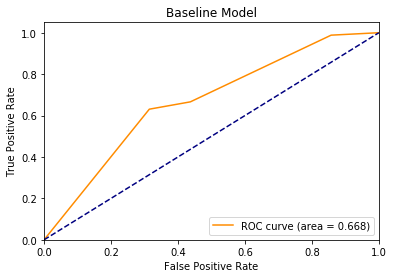

In [667]:
fig, ax = plt.subplots()
plt.plot(fpr_b, tpr_b, color='darkorange', label= f'ROC curve (area = {round(roc_auc_b, 3)})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Baseline Model')
plt.legend(loc="lower right")
plt.show()

### Current Top Model - rep and loyalty scores

In [668]:
# TRAIN
X_train_t = sample_train[['voter_id', 'voting_agency', 'unique_id', 'sponsor_agency', 'district', 
                     'party', 'is_primary_sponsor', 'is_secondary_sponsor', 'is_minority_party', 
                     'primary_sponsor_party', 'rep_score', 'loyalty_score', 'bill_length', 'bill_num', 
                     'num_sponsors', 'years_until_vote']]

y_train_t = sample_train['vote']

# TEST
X_test_t = sample_test[['voter_id', 'voting_agency', 'unique_id', 'sponsor_agency', 'district', 
                     'party', 'is_primary_sponsor', 'is_secondary_sponsor', 'is_minority_party', 
                     'primary_sponsor_party', 'rep_score', 'loyalty_score', 'bill_length', 'bill_num', 
                     'num_sponsors', 'years_until_vote']]

y_test_t = sample_test['vote']

In [ ]:
top_model = RandomForestClassifier(n_estimators=2000, max_depth=7, n_jobs=2, random_state=709)
top_model.fit(X_train_t, y_train_t)
y_pred_t = (top_model.predict_proba(X_test_t))[:, 1]

In [ ]:
log_loss(y_test_t, y_pred_t)

In [640]:
y_pred_t.max()

0.48238707117672075

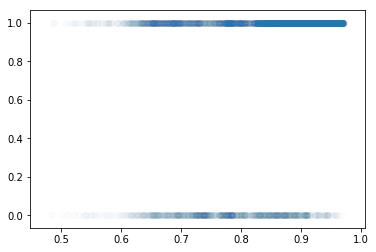

In [641]:
fig, ax = plt.subplots()
ax.scatter(y_pred_t, y_test_t, alpha=0.01)

In [642]:
fpr_t, tpr_t, thresholds_t = roc_curve(y_test_t, y_pred_t)

In [643]:
roc_auc_t = roc_auc_score(y_test_t, y_pred_t)
roc_auc_t

0.7925762710052593

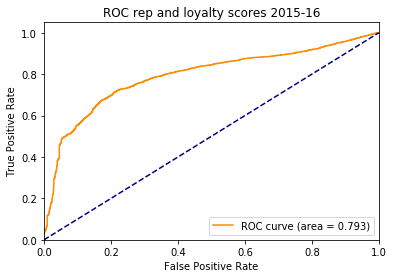

In [644]:
fig, ax = plt.subplots()
plt.plot(fpr_t, tpr_t, color='darkorange', label= f'ROC curve (area = {round(roc_auc_t, 3)})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC rep and loyalty scores 2015-16')
plt.legend(loc="lower right")
plt.show()

### NLP Playground

In [ ]:
# TRAIN
X_train = sample_train[['voter_id', 'voting_agency', 'unique_id', 'sponsor_agency', 'district', 
                     'party', 'is_primary_sponsor', 'is_secondary_sponsor', 'is_minority_party', 
                     'primary_sponsor_party', 'rep_score', 'loyalty_score', 'bill_length', 'bill_num']]

y_train = sample_train['vote']

# TEST
X_test = sample_test[['voter_id', 'voting_agency', 'unique_id', 'sponsor_agency', 'district', 
                     'party', 'is_primary_sponsor', 'is_secondary_sponsor', 'is_minority_party', 
                     'primary_sponsor_party', 'rep_score', 'loyalty_score', 'bill_length', 'bill_num']]

y_test = sample_test['vote']

In [ ]:
bills = sample_train['bill_text']
bills_test = sample_test['bill_text']
len(bills)

In [ ]:
tf = TfidfVectorizer(stop_words=stopwords_nltk, ngram_range=(1, 2), max_df=0.85, max_features=8000)

In [ ]:
fitted = tf.fit(bills)

In [ ]:
transformed_train = tf.transform(bills)

In [ ]:
transformed_test = tf.transform(bills_test)

In [ ]:
def tfidf_transformed_to_dataframe(transformed):
    tfidf_cols = transformed.toarray()
    tfidf_names = fitted.get_feature_names()
    tfidf_df = pd.DataFrame(tfidf_cols, columns=tfidf_names)

    return tfidf_df

In [ ]:
tfidf_train_df = tfidf_transformed_to_dataframe(transformed_train)
X_train = X_train.reset_index().drop('index', axis=1)
X_train = pd.concat([X_train, tfidf_train_df], axis=1)

In [ ]:
tfidf_test_df =  tfidf_transformed_to_dataframe(transformed_test)
X_test = X_test.reset_index().drop('index', axis=1)
X_test = pd.concat([X_test, tfidf_test_df], axis=1)

In [ ]:
X_train.head()

In [ ]:
model = RandomForestClassifier(n_estimators=5000, max_depth=7, n_jobs=2, random_state=709)
model.fit(X_train, y_train)
y_pred = (model.predict_proba(X_test))[:, 1]

In [ ]:
log_loss(y_test, y_pred)

In [ ]:
y_pred.min()

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred, y_test, alpha=0.01)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [ ]:
roc_auc = roc_auc_score(y_test, y_pred)
roc_auc

In [ ]:
fig, ax = plt.subplots()
plt.plot(fpr, tpr, color='darkorange', label= f'ROC curve (area = {round(roc_auc, 3)})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC rep and loyalty scores 2015-16')
plt.legend(loc="lower right")
plt.show()

In [ ]:
features_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns)

In [ ]:
X_train.columns

In [ ]:
features_importances_sorted = features_importances.sort_values(by=0, ascending=False)

In [ ]:
features_importances_sorted

### Topic Playground

In [282]:
topic_df = pd.read_csv('topic_staging_better.csv', sep="|")

In [283]:
topic_df['bill_num_unique'] = topic_df['biennium'] + ' ' + topic_df['bill_num'].apply(str)

In [284]:
topic_df = topic_df.drop('biennium', axis=1)

In [285]:
MERGD = sample_train.merge(topic_df, how='left', on='bill_num_unique')

In [286]:
MERGD_train = MERGD[MERGD['bill_id_y'].notnull()]

In [287]:
MERGD_test = sample_test.merge(topic_df, how='left', on='bill_num_unique')

In [288]:
MERGD_test = MERGD_test[MERGD_test['bill_id_y'].notnull()]

In [289]:
# TRAIN
X_train = MERGD_train.drop(['vote', 'vote_date', 'bill_unique', 'biennium', 'bill_id_y', 'bill_id_x', 'htm_url',
                                    'bill_text', 'bill_num_unique', 'secondary_sponsors', 
                                    'primary_sponsor_id', 'congress_num', 'dem_score'], axis=1)

y_train = MERGD_train['vote']

# TEST
X_test = MERGD_test.drop(['vote', 'vote_date', 'bill_unique', 'biennium', 'bill_id_y', 'bill_id_x', 'htm_url',
                                    'bill_text', 'bill_num_unique', 'secondary_sponsors', 
                                    'primary_sponsor_id', 'congress_num', 'dem_score'], axis=1)

y_test = MERGD_test['vote']

In [306]:
model = RandomForestClassifier(n_estimators=3000, max_depth=6, n_jobs=2, random_state=709)
model.fit(X_train, y_train)
y_pred = (model.predict_proba(X_test))[:, 1]

In [307]:
log_loss(y_test, y_pred)

0.4406597647288424

In [308]:
y_pred.min()

0.7488319675217525

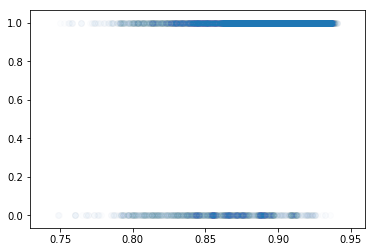

In [309]:
fig, ax = plt.subplots()
ax.scatter(y_pred, y_test, alpha=0.01)

In [310]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [311]:
roc_auc = roc_auc_score(y_test, y_pred)
roc_auc

0.7635124840885809

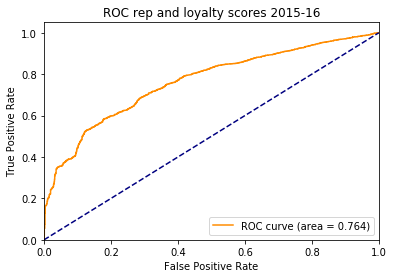

In [312]:
fig, ax = plt.subplots()
plt.plot(fpr, tpr, color='darkorange', label= f'ROC curve (area = {round(roc_auc, 3)})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC rep and loyalty scores 2015-16')
plt.legend(loc="lower right")
plt.show()

In [313]:
features_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns)

In [314]:
features_importances_sorted = features_importances.sort_values(by=0, ascending=False)

In [315]:
features_importances_sorted.head()

,0
bill_length,0.128374
rep_score,0.115128
percent_yea,0.089915
is_minority_party,0.065150
num_sponsors,0.058486


In [ ]:
group = sample_one_year.groupby('vote')

In [ ]:
group.mean()

# Model to Pickle

# Explore bill_text

In [317]:
nays = sample[sample['vote'] == 0]
yeas = sample[sample['vote'] == 1]

yeas.head()

,vote,vote_date,voter_id,voting_agency,bill_unique,unique_id,biennium,bill_id,htm_url,sponsor_agency,...,bill_num,bill_num_unique,index,secondary_sponsors,primary_sponsor_id,rep_score,dem_score,bill_length,congress_num,num_sponsors
402049,1,1991-04-23,50,0,1991-92 SHB 2048,2112.0,1991-92,SHB 2048,http://app.leg.wa.gov/documents/billdocs/1991-...,0,...,2048,1991-92 2048,2108,"{46,285,32,337,410,322,325,475,406,394,304,396...",297,0.733333,0.266667,12096,1,13
2536082,1,2012-04-10,972,1,2011-12 HB 2822,82581.0,2011-12,HB 2822,http://app.leg.wa.gov/documents/billdocs/2011-...,0,...,2822,2011-12 2822,82578,None,8222,0.000000,1.000000,5043,21,1
2194989,1,2009-04-17,8159,1,2009-10 SHB 1332,71367.0,2009-10,SHB 1332,http://app.leg.wa.gov/documents/billdocs/2009-...,0,...,1332,2009-10 1332,71363,"{5160,8209,12002,10039,5157,9710,11997,14204,8...",11999,0.200000,0.800000,5474,19,12
274203,1,1996-02-05,646,0,1995-96 SHB 2163,16873.0,1995-96,SHB 2163,http://app.leg.wa.gov/documents/billdocs/1995-...,0,...,2163,1995-96 2163,16871,"{1660,1594,1592,1583}",1583,1.000000,0.000000,3030,5,5
2773335,1,2014-02-12,2142,1,2013-14 ESB 6034,91603.0,2013-14,ESB 6034,http://app.leg.wa.gov/documents/billdocs/2013-...,1,...,6034,2013-14 6034,91599,"{564,17226,8211,171,5163}",5163,0.200000,0.800000,12221,23,6


In [541]:
print(yeas.loc[402049, 'bill_text'])














CERTIFICATION OF ENROLLMENT

SUBSTITUTE HOUSE BILL 2048


Chapter
229, Laws of 1991


52nd
Legislature
1991
Regular Session


PHARMACISTS‑-LICENSE RENEWAL
FEES


EFFECTIVE
DATE:  7/28/91







Passed by the House
March 13, 1991

Yeas 97   Nays 0


JOE
KING
Speaker of the
House of
Representatives

Passed by the Senate
April 12, 1991

Yeas 44   Nays 0


JOEL
PRITCHARD
President of the Senate


Approved May 16, 1991







BOOTH
GARDNER
Governor of the State of
Washington


CERTIFICATE

I, Alan Thompson, Chief Clerk of
the House of Representatives of the State of Washington, do hereby certify that
the attached is SUBSTITUTE HOUSE BILL 2048 as passed by the House of
Representatives and the Senate on the dates hereon set forth.



ALAN
THOMPSON
Chief Clerk


FILED




May 16, 1991 -
10:53 a.m.



Secretary
of State
State of
Washington









_______________________________________________

SUBSTITUTE
HOUSE BILL 2048
_______________________________________________

AS
AMENDED

In [399]:
print(nays.loc[1603, 'bill_text'])





5451-S2.E




_______________________________________________

ENGROSSED SECOND
SUBSTITUTE SENATE BILL 5451
_______________________________________________

State of Washington                              53rd
Legislature                             1993 Regular Session

By Senate Committee on Ways & Means (originally sponsored
by Senator Hargrove)

Read
first time 04/05/93.


Revising sentencing and corrections for felons.




AN ACT Relating to persons convicted of
felonies; amending RCW 9.94A.390, 9.95.0011, 9.95.210, 9.96.050, 9A.20.021,
43.19.534, 72.09.070, 72.09.080, 72.09.110, and 72.60.160; reenacting and
amending RCW 9.94A.030, 9.94A.120, and 9.94A.440; adding new a section to
chapter 72.09 RCW; creating new sections; repealing RCW 72.09.102 and
72.60.190; and prescribing penalties.

BE
IT ENACTED BY THE LEGISLATURE OF THE STATE OF WASHINGTON:

NEW SECTION.  Sec. 1.
The legislature finds that crowded prisons are clearly one of the most pressing
problems facing the crimin

In [538]:
bill_text_df.head()

,index,unique_id,htm_url,bill_text
0,0,8893.0,http://app.leg.wa.gov/documents/billdocs/1993-...,1790.sl certification of enrol...
1,70,8895.0,http://app.leg.wa.gov/documents/billdocs/1993-...,bp bhead int h z-0780.1 ...
2,79,8909.0,http://app.leg.wa.gov/documents/billdocs/1993-...,1800.sl certification of enrol...
3,120,8896.0,http://app.leg.wa.gov/documents/billdocs/1993-...,1792-s h-2097.1 _____...
4,127,8920.0,http://app.leg.wa.gov/documents/billdocs/1993-...,bp bhead int h h-1277.1 ...


In [537]:
def clean_bill_text(bill_text):
    bill_text_lower = bill_text.lower()
    bill_text_prepared = bill_text_lower.replace('\n', ' ') 
    return bill_text_prepared

bill_text_df['bill_text'] = bill_text_df['bill_text'].apply(prepare_bill_text)

In [ ]:
def find_read_first_time_date(bill_text):
    '''Find first_read_date from the bill text. Bills have different formatting.'''
    try:
        bill_split = bill_text.split('first time ')[1]
        end_points = range(26)
        all_datetimes = []
        for end_point in end_points:
            try:
                date = pd.DatetimeIndex(bill_split[0:end_point])
            except:
                date = ''
            if type(date) != str:
                all_datetimes.append(date)
        correct_date = all_datetimes[-1]
        return correct_date
    except:
        return None
        

In [545]:
test = yeas.loc[402049, 'bill_text']

In [587]:
bill_split = test.split('first time ')[1]

In [554]:
end 

In [595]:
end_points = range(2, 26)
all_datetimes = []
for end_point in end_points:
    try:
        date = pd.Timestamp(bill_split[0:end_point])
    except:
        date = ''
    if type(date) != str:
        all_datetimes.append(date)

In [596]:
all_datetimes

[Timestamp('2001-03-04 00:00:00'),
 Timestamp('2019-03-04 00:00:00'),
 Timestamp('1991-03-04 00:00:00'),
 Timestamp('1991-03-04 00:00:00')]

In [592]:
pd.bill_split[0:13]

'March 4, 1991'

In [444]:
woops = bill_text_df[bill_text_df['first_date_read'] == 'woop']

In [445]:
woops.head()

,index,unique_id,htm_url,bill_text,first_date_read
465,67208,11163.0,http://app.leg.wa.gov/documents/billdocs/1993-...,"4678 house resolution no. 94-4678, by ...",woop
1595,259413,16734.0,http://app.leg.wa.gov/documents/billdocs/1995-...,2080-s.vto veto message on hb 2080-s j...,woop
3830,603380,17895.0,http://app.leg.wa.gov/documents/billdocs/1995-...,2695-s.vto [atlas:digest] veto message...,woop
4063,631268,18863.0,http://app.leg.wa.gov/documents/billdocs/1995-...,5108.vto veto message on sb 5108 may 1...,woop
5889,899086,27165.0,http://app.leg.wa.gov/documents/billdocs/1997-...,veto message on sb 5191-s veto message...,woop


In [483]:
test_woop = woops.iloc[1, -2]

In [484]:
woop_split = test_woop.split()

In [485]:
test_woop

'    2080-s.vto     veto message on hb 2080-s june 16, 1995 to the honorable speaker and members, the house of representatives of the state of washington ladies and gentlemen: i am returning herewith, without my approval as to sections 2(2); 105(2); 106 (lines 3-10); 107 (lines 14-18); 207(1); 207(2); 207(3); 207(4); 208(4); 217 (lines 26-27); 217 (lines 32-33); 217(17); 228(2); 228(4); 305; 504; 529; 531; 532; 537; 539; 540; 542-557; 559 and 560, second engrossed substitute house bill no. 2080 entitled: "an act relating to transportation funding and appropriations;" the provisions of second engrossed substitute house bill no. 2080 not meeting my approval are addressed as follows:  section 2(2), page 2, transportation appropriations this proviso states that legislation with a fiscal impact enacted in the 1995 session that is not assumed in this bill is not funded in the transportation budget.\xa0 the language is ambiguous and i am concerned that this administrative restriction sets a b

In [337]:
example_text = yeas.loc[402049, 'bill_text']

In [338]:
example_text = example_text.lower()

In [359]:
(example_text.split('first time')[1])[0:20]

' march 4, 1991.lower'

### TFIDFVectorizer

In [ ]:
bills = sample_one_year['bill_text']

In [ ]:
bills.shape

In [ ]:
wordnet = WordNetLemmatizer()

In [ ]:
def create_bill_tokens(bill):
    bill = bill.replace('\n', ' ') 
    punctuations = set(string.punctuation)
    
    bill = ''.join([char.lower() for char in bill if char not in punctuations])
    bill_tokens = bill.split(' ')
    lemmed_bill = [wordnet.lemmatize(word) for word in bill_tokens] 
    
    return lemmed_bill

In [ ]:
my_stopwords = ['shall', 'chapter', 'provided', 'year', 'person', 'department', 'appropriation', 'provided'
                 'information', 'provide', 'including', 'following', 'section', 'sec', 'year', 'subsection', 
                'agency', 'required',  'use', 'solely', 'ii', 'defined', 'approved', 'does',  'period', 
                'rcw 43', 'persons', 'individual', 'unless', '9a', '28a', 'purpose', '28b',  'washington',  
                'fy',  'iii', 'sec rcw', 'rcw9a', 'rcw',  'apply',  '000general',  '000', 'related',  'sp', 
                'make', 'includes', 'end', 'biennia', 'set', 'terms', 'total', 'level', 'amended', 
                'engrossed', 'substitute', 'legislature', 'enacted', 'passed', 'add', 'additional', 'new', 'board',
                'limited', 'date', 'order', 'plan', 'percent', 'support', 'director', 'child', 'two', 'years', 
                'committee', 'five', 'laws', 'contract', 'prior', 'necessary', 'requirements', 'days', 'based', 
                'made', 'except', 'per', 'number', 'amounts', 'conditions', 'senate', 'house', 'system', 'may',
               'must', 'account', 'one', 'means', 'within', 'county', 'general', 'subject', 'within', 'treatment', 
               'service', 'include', 'used', 'account', 'less', 'part', 'member', 'established', 'law', 'rate', 
                'read', 'follows', 'information', 'program', 'services', 'fund', 'amount', 'agreement', 'payment',
               'commission', 'notice', 'legislature2015', '02', '1st', 'april', 'beginning', 'december', 'january', 
                'february', 'march', 'may', 'june', 'july', 'august', 'sepetmeber', 'november', 'manner', 'plans',
               'need', '060', 'sections', 'either', 'described', 'equivalent', 'recommendations', 'office', 'created',
               'higher', 'hours', 'written', 'address', 'organizations', 'value', 'party', 'full', '030', 'high', 'case',
               'four', '04', 'would', '05', 'day', 'whether', 'pass', '040', 'yeas', 'nays', 'absents', 'yea', 'nay',
                'absents', 'undecided', 'undecideds']

stop_nums = list(set([str(num) for num in range(0, 2025)]))
stopwords_nltk = list(set(stopwords.words('english')))

In [ ]:
stopwords_nltk.extend(my_stopwords)
stopwords_nltk.extend(stop_nums)
stopwords_nltk = set(stopwords_nltk)

In [ ]:
analyzer=create_bill_tokens, 

In [ ]:
tf = TfidfVectorizer(stop_words=stopwords_nltk, ngram_range=(1, 2), max_df=0.9, max_features=5000)
fitted = tf.fit(bills)
transformed = tf.transform(bills)
fitted = tf.fit(bills)
transformed = tf.transform(bills)
vocab = tf.vocabulary_
vocab

tfidf_cols = transformed.toarray()

tfidf_names = fitted.get_feature_names()

tfidf_df = pd.DataFrame(tfidf_cols, columns=tfidf_names)

tfidf_df.head()

tfidf_df.shape

In [ ]:
fitted = tf.fit(bills)

In [ ]:
transformed = tf.transform(bills)

In [ ]:
vocab = tf.vocabulary_

In [ ]:
vocab

In [ ]:
tfidf_cols = transformed.toarray()

In [ ]:
tfidf_names = fitted.get_feature_names()

In [ ]:
tfidf_df = pd.DataFrame(tfidf_cols, columns=tfidf_names)

In [ ]:
tfidf_df.head()

In [ ]:
tfidf_df.shape

In [ ]:
# cv = CountVectorizer(stop_words=stopwords_nltk, analyzer='word', ngram_range=(1, 4), max_df=0.9, max_features = 200000)
# cv_fit = cv.fit_transform(bills)
# word_counts = pd.DataFrame(cv_fit.toarray(), columns= cv.get_feature_names())
# word_counts = word_counts.sum(axis=0)
# words_sorted = word_counts.sort_values(ascending=False)
# words_sorted_only = words_sorted.index
# for word in words_sorted_only [100:150]:
#     print(word)

In [ ]:
features_importances_sorted[0:50]